# Imports and data

In [1]:
from swifter import swiftapply
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

These data (~71 million rows) were taken from https://www.kaggle.com/benhamner/sf-bay-area-bike-share/data 

In [2]:
data = pd.read_feather('/home/ec2-user/data/status')
data['date'] = pd.to_datetime(data['time'])

In [10]:
print(data.shape)
data.head()

(71984434, 5)


,station_id,bikes_available,docks_available,time,date
0,2,2,25,2013/08/29 12:06:01,2013-08-29 12:06:01
1,2,2,25,2013/08/29 12:07:01,2013-08-29 12:07:01
2,2,2,25,2013/08/29 12:08:01,2013-08-29 12:08:01
3,2,2,25,2013/08/29 12:09:01,2013-08-29 12:09:01
4,2,2,25,2013/08/29 12:10:01,2013-08-29 12:10:01


# Necessary functions for timing and plotting

In [7]:
import dask.dataframe as dd
from dask.multiprocessing import get

def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def pd_apply(df, myfunc, *args, **kwargs):
    def wrapped():
        return df.apply(myfunc, args=args, **kwargs)
    return wrapped

def dask_apply(df, npartitions, myfunc, *args, **kwargs):
    if type(df) == pd.DataFrame:
        kwargs.pop('meta')
        tmp = df.iloc[:1,:].apply(myfunc, args=args, **kwargs)
        meta = {c: tmp[c].dtype for c in tmp.columns}
        return dd.from_pandas(df, npartitions=npartitions).apply(myfunc, *args, axis=1, **kwargs, meta=meta).compute(get=get)
    else:
        meta = kwargs.pop('meta')
        try:
            return dd.from_pandas(df, npartitions=npartitions).map_partitions(myfunc, *args, **kwargs, meta=meta).compute(get=get)
        except:
            return dd.from_pandas(df, npartitions=npartitions).map(lambda x: myfunc(x), *args, **kwargs, meta=meta).compute(get=get)

In [8]:
from psutil import cpu_count
import timeit


def time_all(df, my_func, nrows, *args, **kwargs):
    pd_times = list()
    dask_times = list()
    vectorized_times = list()
    swiftapply_times = list()
    meta = df.iloc[:2].apply(lambda x: my_func(x, *args, **kwargs))
    n_reps = 1

    for rows in nrows:
        print(rows)
        my_sample = df.iloc[:rows]

        print('pd')
        wrapped = pd_apply(my_sample, my_func, *args, **kwargs)
        pd_times.append(timeit.timeit(wrapped, number=n_reps)/n_reps)
                
        print('dask')
        wrapped = wrapper(dask_apply, my_sample, cpu_count()*2, my_func, *args, meta=meta, **kwargs)
        dask_times.append(timeit.timeit(wrapped, number=n_reps)/n_reps)

        try:
            print('vec')
            wrapped = wrapper(my_func, my_sample, *args, **kwargs)
            vectorized_times.append(timeit.timeit(wrapped, number=n_reps)/n_reps)
        except:
            vectorized_times.append(None)

        print('swift')
        wrapped = wrapper(swiftapply, my_sample, my_func, *args, **kwargs)
        swiftapply_times.append(timeit.timeit(wrapped, number=n_reps)/n_reps)
        
    return pd.DataFrame({'pd_apply': pd_times, 'dask_apply': dask_times, 
                         'vectorized': vectorized_times, 'swiftapply': swiftapply_times})


In [12]:
def plot_times(df, log10=False):
    if any([time is not None for time in df['vectorized']]):
        vectorized = True
    else:
        vectorized = False
    if log10:
        plt.plot(np.log10(nrows), np.log10(df['pd_apply']), '-r')
        plt.plot(np.log10(nrows), np.log10(df['dask_apply']), '-b')
        if vectorized:
            plt.plot(np.log10(nrows), np.log10(df['vectorized']), '-c')
        plt.plot(np.log10(nrows), np.log10(df['swiftapply']), '-g')
        plt.xlabel('log10(Rows)')
        plt.ylabel('log10(Time (seconds))')
    else:
        plt.plot(nrows, df['pd_apply'], '-r')
        plt.plot(nrows, df['dask_apply'], '-b')
        if vectorized:
            plt.plot(nrows, df['vectorized'], '-c')
        plt.plot(nrows, df['swiftapply'], '-g')
        plt.xlabel('Rows')
        plt.ylabel('Time (seconds)')
    if vectorized:
        plt.legend(['Pandas apply', 'Dask apply', 'Vectorized', 'swiftapply'])
    else:
        plt.legend(['Pandas apply', 'Dask apply', 'swiftapply'])
    plt.box(on=False)

# Vectorizable functions

In [6]:
def bikes_proportion(x, max_x):
    return x * 1.0 / max_x

In [24]:
n = data.shape[0]
nrows = [round (n/47828125), round(n/9565625), round(n/1953125), round(n/390625),
              round(n/78125), round(n/15625), round(n/3125),
              round(n/625), round(n/125), round(n/25), round(n/5), n]
%time bikesproportion_times = time_all(data['bikes_available'], bikes_proportion, nrows, max_x=np.max(data['bikes_available']))

2
pd
dask
vec
swift
8
pd
dask
vec
swift
37
pd
dask
vec
swift
184
pd
dask
vec
swift
921
pd
dask
vec
swift
4607
pd
dask
vec
swift
23035
pd
dask
vec
swift
115175
pd
dask
vec
swift
575875
pd
dask
vec
swift
2879377
pd
dask
vec
swift
14396887
pd
dask
vec
swift
71984434
pd
dask
vec
swift
CPU times: user 4min 42s, sys: 23.1 s, total: 5min 5s
Wall time: 5min 3s


In [ ]:
#bikes_proportion.to_csv('bikesproportion_times.csv', index=False)

In [68]:
#bikesproportion_times = pd.read_csv('bikesproportion_times.csv')

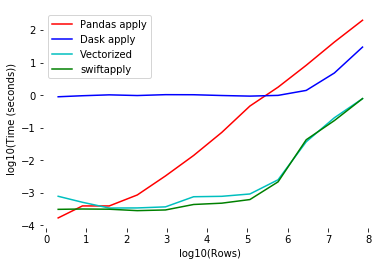

In [28]:
plot_times(bikesproportion_times, True)

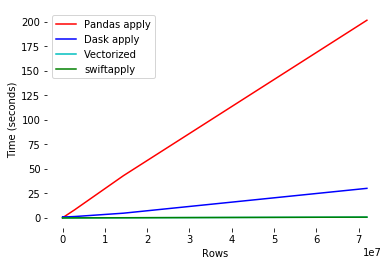

In [29]:
plot_times(bikesproportion_times, False)

In [15]:
n = data.shape[0]
nrows = [round (n/47828125), round(n/9565625), round(n/1953125), round(n/390625), 
              round(n/78125), round(n/15625), round(n/3125),
              round(n/625), round(n/125), round(n/25), round(n/5), n]
%time datetime_times = time_all(data['time'], pd.to_datetime, nrows)

2
pd
dask
vec
swift
8
pd
dask
vec
swift
37
pd
dask
vec
swift
184
pd
dask
vec
swift
921
pd
dask
vec
swift
4607
pd
dask
vec
swift
23035
pd
dask
vec
swift
115175
pd
dask
vec
swift
575875
pd
dask
vec
swift
2879377
pd
dask
vec
swift
14396887
pd
dask
vec
swift
71984434
pd
dask
vec
swift
CPU times: user 1h 39min 14s, sys: 39.8 s, total: 1h 39min 54s
Wall time: 1h 40min 16s


In [18]:
#datetime_times.to_csv('datetime_conversion_times.csv', index=False)

In [70]:
#datetime_times = pd.read_csv('datetime_conversion_times.csv')

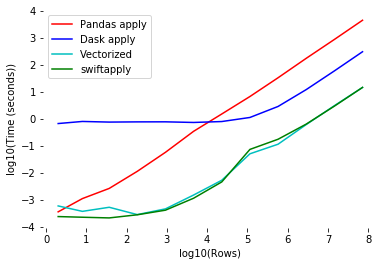

In [16]:
plot_times(datetime_times, True)

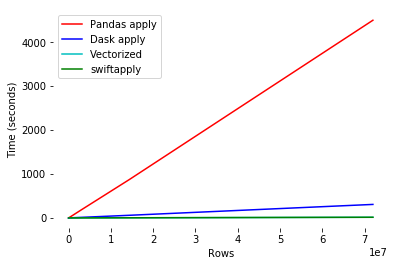

In [17]:
plot_times(datetime_times, False)

# Non-vectorized functions

In [5]:
def is_morning(datetime):
    if (datetime.hour >= 6) and (datetime.hour < 12):
        return True
    else:
        return False

In [13]:
n = data.shape[0]
nrows = [round (n/47828125), round(n/9565625), round(n/1953125), round(n/390625),
              round(n/78125), round(n/15625), round(n/3125),
              round(n/625), round(n/125), round(n/25), round(n/5), n]
%time ismorning_times = time_all(data['date'], is_morning, nrows)

2
pd
dask
vec
swift
8
pd
dask
vec
swift
37
pd
dask
vec
swift
184
pd
dask
vec
swift
921
pd
dask
vec
swift
4607
pd
dask
vec
swift
23035
pd
dask
vec
swift
115175
pd
dask
vec
swift
575875
pd
dask
vec
swift
2879377
pd
dask
vec
swift
14396887
pd
dask
vec
swift
71984434
pd
dask
vec
swift


In [ ]:
#ismorning_times.to_csv('ismorning_times.csv', index=False)

In [21]:
#ismorning_times = pd.read_csv('ismorning_times.csv')

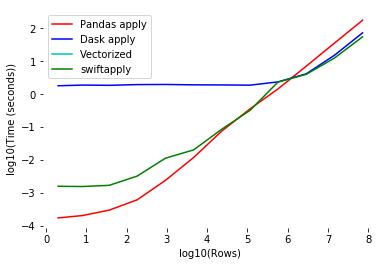

In [22]:
plot_times(ismorning_times, True)

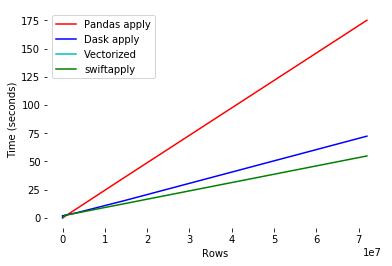

In [23]:
plot_times(ismorning_times, False)

In [4]:
def convert_to_human(datetime):
    return datetime.weekday_name + ', the ' + str(datetime.daysinmonth) + 'th day of ' + datetime.strftime("%B") + ', ' + str(datetime.year)

In [9]:
n = data.shape[0]
nrows = [round (n/47828125), round(n/9565625), round(n/1953125), round(n/390625), 
              round(n/78125), round(n/15625), round(n/3125),
              round(n/625), round(n/125), round(n/25), round(n/5), n]
%time humanreadable_times = time_all(data['date'], convert_to_human, nrows)

2
pd
dask
vec
swift
8
pd
dask
vec
swift
37
pd
dask
vec
swift
184
pd
dask
vec
swift
921
pd
dask
vec
swift
4607
pd
dask
vec
swift
23035
pd
dask
vec
swift
115175
pd
dask
vec
swift
575875
pd
dask
vec
swift
2879377
pd
dask
vec
swift
14396887
pd
dask
vec
swift
71984434
pd
dask
vec
swift
CPU times: user 47min 6s, sys: 2min 32s, total: 49min 38s
Wall time: 1h 4min 47s


In [19]:
#humanreadable_times.to_csv('humanreadable_conversion_times.csv', index=False)

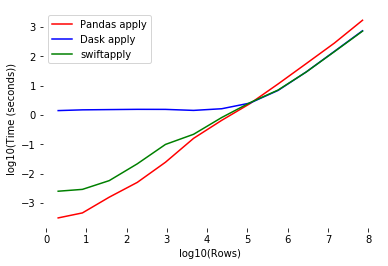

In [13]:
plot_times(humanreadable_times, True)

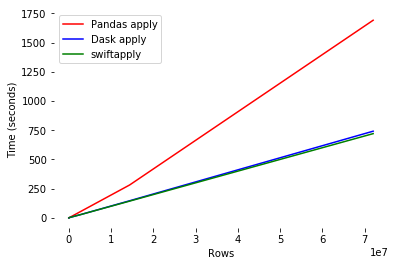

In [14]:
plot_times(humanreadable_times, False)